# Explanation pipeline

In [1]:
# Reload modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

# Import from code root directory
import sys; sys.path.insert(0, '../')

# Imports
from collections import OrderedDict
from access.amazon_doc2vec_reader import AmoreDoctovecReader
from detection.bounding_boxes import BoundingBoxes
from explanations.count_explainer import CountExplainer
from explanations.tfidf_explainer import TfidfExplainer
from explanations.wordcloud import Wordcloud
from explorer.search import Search

## Data Readers

- Implementations of `ReaderInterface`.
- Creates `reader` instance.

In [2]:
# AMORE test 1
# 10,000 1-star items from 2007
# 10,000 5-star items from 2007
if True:
    reader = AmoreDoctovecReader()
    options = {}
    options['data_directory']     = '/home/eml4u/EML4U/data/amazon-complete'
    options['distributions_file'] = '/tmp/amore_test_1.pickle'
    reader.initialize(options)
    reader.get_dimensions() # Method also reads all data

AmoreDoctovecReader distributions file: /tmp/amore_test_1.pickle
AmoreDoctovecReader data directory:     /home/eml4u/EML4U/data/amazon-complete
AmoreDoctovecReader: Loading distribution file: /tmp/amore_test_1.pickle
AmazonPickleReader: Reading raw data
AmazonPickleReader: Reading bow50 data
Dimensions: 50


In [3]:
# AMORE test 2
# 2011: 25K positive and 25K negative
# 2012: 40K positive and 10K negative
if False:
    reader = AmoreDoctovecReader()
    options = {}
    options['data_directory']     = '/home/eml4u/EML4U/data/amazon-complete'
    options['distributions_file'] = '/tmp/amore_test_2.pickle'
    reader.initialize(options)
    reader.get_dimensions() # Method also reads all data

## Distribution information

In [4]:
distribution_a_id = reader.get_distribution_ids()[0]
distribution_b_id = reader.get_distribution_ids()[1]

print('Distribution IDs:', distribution_a_id, distribution_b_id)
print('Size', str(distribution_a_id) + ':', len(reader.get_item_ids(distribution_a_id)))
print('Size', str(distribution_b_id) + ':', len(reader.get_item_ids(distribution_b_id)))
print('Dimensions:', reader.get_dimensions())

Distribution IDs: 0 1
Size 0: 10000
Size 1: 10000
Dimensions: 50


## Drift Detectors

Implementations of `DetectionInterface`.

In [5]:
# Gets outliers based on boundaries derived from single dimension values.
detector = BoundingBoxes()
detector.initialize({
    'percentile':          0.995,
    'enclosed_dimensions': 50
})
detector.set_reader(reader)

BoundingBoxes percentile:                            0.995
BoundingBoxes minimum number of enclosed dimensions: 50


In [6]:
# Detect drift and save results in drift_results
drift_results = OrderedDict()
drift_results[distribution_a_id] = detector.select_item_ids(distribution_a_id, distribution_b_id)
drift_results[distribution_b_id] = detector.select_item_ids(distribution_b_id, distribution_a_id)
print('Drift result IDs:', drift_results.keys())
print('Drift result numbers of items ' + str(distribution_a_id) + ':', len(drift_results[distribution_a_id]), '/', len(reader.get_item_ids(distribution_a_id)), end='')
print(' (' + str(round(100*len(drift_results[distribution_a_id])/len(reader.get_item_ids(distribution_a_id)), 2)), '%)')
print('Drift result numbers of items ' + str(distribution_b_id) + ':', len(drift_results[distribution_b_id]), '/', len(reader.get_item_ids(distribution_b_id)), end='')
print(' (' + str(round(100*len(drift_results[distribution_b_id])/len(reader.get_item_ids(distribution_b_id)), 2)), '%)')

BoundingBoxes: Collecting values of single dimensions
BoundingBoxes: Updating boundaries
BoundingBoxes: Filtering items
BoundingBoxes: Collecting values of single dimensions
BoundingBoxes: Updating boundaries
BoundingBoxes: Filtering items
Drift result IDs: odict_keys([0, 1])
Drift result numbers of items 0: 2310 / 10000 (23.1 %)
Drift result numbers of items 1: 4347 / 10000 (43.47 %)


## Drift Explainers

Note: TF-IDF values of tokens in single detected documents are just summed up in the current version.

In [7]:
if True:
    explainer = TfidfExplainer()
    explainer.initialize({'max_results':50})

TfidfExplainer max_results: 50


In [8]:
if False:
    explainer = CountExplainer()
    explainer.initialize({'max_results':50})

In [9]:
token_dict_a = explainer.get_token_dict(drift_results[distribution_a_id], drift_results[distribution_b_id], reader)
print(token_dict_a)

{'season': 0.0017678782277709979, 'great': 0.0013585335837233326, 'series': 0.000757755130812334, 'best': 0.0007329313802585697, 'excellent': 0.0006974160188156836, 'love': 0.0006903283952794094, 'awesome': 0.00046749282476008316, 'amazing': 0.00042216823902583786, 'wonderful': 0.00041244189665145517, 'seasons': 0.00040687874561840215, 'episodes': 0.0003916292149546638, 'loved': 0.0003620584609037614, 'collection': 0.0003562514146893883, 'fantastic': 0.00031120200430159256, 'favorite': 0.00030989402587626577, 'shows': 0.000307727181815768, 'episode': 0.0002885538104140979, 'perfect': 0.0002707597022969443, 'fun': 0.0002559821376211636, 'condition': 0.00024249419023883272, 'jane': 0.0002267925150456826, 'highly': 0.00021877578403451276, 'wait': 0.00018864919398704132, 'rochester': 0.000184544994467267, 'set': 0.00018385706942199772, 'hilarious': 0.00017521603301877273, 'outstanding': 0.00017436836886753598, 'gift': 0.00017384954558896553, 'loves': 0.00017047322452023886, 'pleased': 0.00

In [10]:
token_dict_b = explainer.get_token_dict(drift_results[distribution_b_id], drift_results[distribution_a_id], reader)
print(token_dict_b)

{'movie': 0.0057426881840407, 'film': 0.0026740202257373707, 'bad': 0.0023078893041135772, 'waste': 0.0019878126004686495, 'money': 0.0017938174229347528, 'don': 0.0016987992587741236, 'worst': 0.0015641966938124347, 'just': 0.001478921411728566, 'like': 0.0014582438636611872, 'time': 0.0012316820825350014, 'boring': 0.0012249181579350574, 'movies': 0.0011582884676040863, 'horrible': 0.0010920371735459187, 'acting': 0.0010702351241392732, 'awful': 0.001039640633099535, 'poor': 0.0010122225866272382, 'plot': 0.0010021448987033287, 'did': 0.0009733816895209889, 'terrible': 0.0009725783740175077, 'really': 0.0009719797958441375, 'people': 0.0009509320181930831, 'story': 0.0009469503569234457, 'minutes': 0.0008858186563753694, 'make': 0.0008849153840496968, 'stupid': 0.000879257017937022, 'didn': 0.0008064922508337412, 'seen': 0.0007526188129590805, 'horror': 0.0007349953953675848, 'disappointed': 0.0007209071273353816, 'know': 0.0007199966589772446, 'watch': 0.0007054714438621938, 'funny'

### Visual representations

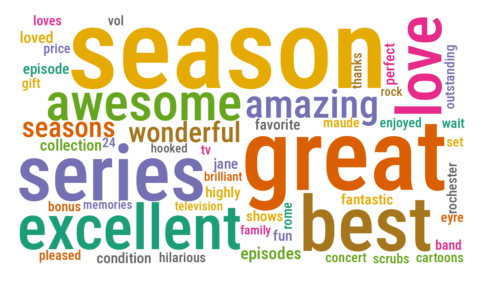

In [11]:
wordcloud = Wordcloud()
wordcloud.plot(wordcloud.get_wordcloud(token_dict_a))

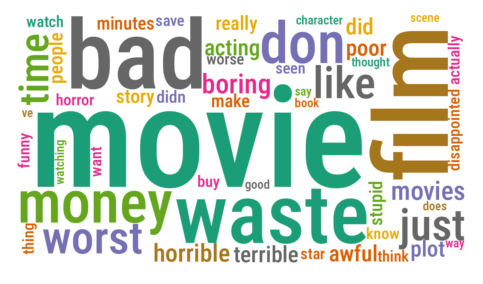

In [12]:
wordcloud = Wordcloud()
wordcloud.plot(wordcloud.get_wordcloud(token_dict_b))

## Explorer

In [13]:
search = Search()
search.initialize({'reader':reader})

In [14]:
query = 'season'

In [15]:
search_results_a = search.search(query, item_ids=drift_results[distribution_a_id], max=-1)

Searched in 2310 items
Found 425 items (18.4 %)


In [16]:
search_results_b = search.search(query, item_ids=drift_results[distribution_b_id], max=-1)

Searched in 4347 items
Found 122 items (2.81 %)


In [17]:
# Print item IDs and texts
#search.print_results(search_results_a, max=10)

In [18]:
# Print item IDs and texts
#search.print_results(search_results_b, max=10)